# **SELF DRIVING CAR**

## 1.Importing libraries

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import pi
from itertools import islice
import cv2
import tensorflow as tf
import pickle
import scipy

## 2.Reading images names from text file

In [7]:
#reading the data set from data.txt

dataset_path='H:\Case Study\Self Driving Case Study\Autopilot-TensorFlow-master\Autopilot-TensorFlow-master\driving_dataset'
training_path=os.path.join(dataset_path,'data.txt')

split=0.8
X=[]
y=[]

#islice(text, start, stop, LIMIT) --> ('ABCDEF', 2, None) --> 'C D E F'  -->https://docs.python.org/2/library/itertools.html
with open(training_path) as f:
    for line in islice(f,None):
        path,angle=line.strip().split()
        full_path=os.path.join(dataset_path,path)
        X.append(full_path)
        y.append((float(angle)*pi)/180)
        
y=np.array(y)

print("Finished Preprocessing")

#split it with 80/20

split_index=int(len(y)*0.8)
y_train=y[:split_index]
y_val=y[split_index:]

Finished Preprocessing


## Understanding the variables

#### 1.training_path contains the path to the data.txt file in local system
#### 2.X is a list which contains the path to each image
#### 3.y is list which contains the angle of the above images

### 2.1 Base Model

C:\Users\Sumit Chhabra\anaconda3\envs\Latest_Environment\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Sumit Chhabra\anaconda3\envs\Latest_Environment\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


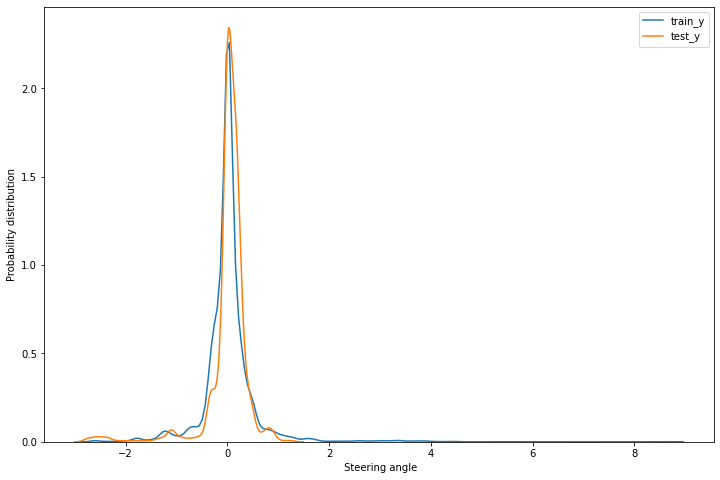

In [8]:
#distribution of train and test y
plt.figure(figsize=(12,8))
sns.distplot(y_train, hist=False, label='train_y')
sns.distplot(y_val, hist=False, label='test_y')
plt.xlabel(' Steering angle')
plt.ylabel('Probability distribution')
plt.legend()
plt.show()

In [9]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(y_train)

print('Test_MSE(MEAN):%f' % np.mean(np.square(y_val-train_mean_y)) )
print('Test_MSE(ZERO):%f' % np.mean(np.square(y_val-0.0)) )

Test_MSE(MEAN):0.191127
Test_MSE(ZERO):0.190891


In [10]:
print(len(y_train))
print(len(y_val))

36324
9082


In [11]:
print(len(X[:len(y_train)]))
print(len(X[len(y_train):]))

36324
9082


In [12]:
print(X[0])

H:\Case Study\Self Driving Case Study\Autopilot-TensorFlow-master\Autopilot-TensorFlow-master\driving_dataset\0.jpg


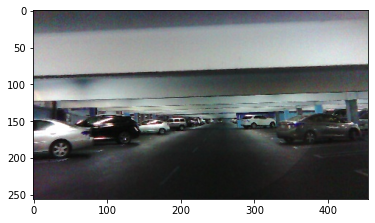

In [13]:
import cv2
img=cv2.imread(X[0])

plt.imshow(img)
plt.show()

#### Observation: Since training CNN is computationaly expensive, thus we need to remove the unnecessary noise in the data. In our case, our important features are pixels that capture the path/road. Rest of the image portion doesn't add any value in training our data.

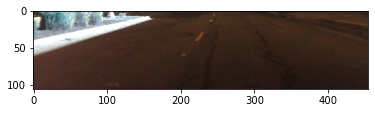

******************************
shape after resizing it: (66, 200, 3)


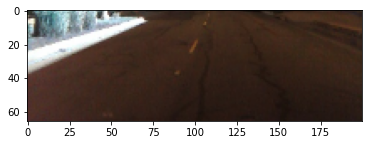

In [14]:
#Nvidia requires us to give an input of image of size 66,200
# Figuring out the portion of images to be removed.

img=cv2.imread(X[1500])
img=img[150:]
plt.imshow(img)
plt.show()
print('******************************')
resized_img = cv2.resize(img, (200,66))  # 200/66 = 455/150 = 3.03 => we are keeping aspect ratio when we are resizing it
print('shape after resizing it:', resized_img.shape)
plt.imshow(resized_img)
plt.show()

### 3.2 Doing the same for all images

In [15]:
X_train=[]
for i in X[:len(y_train)]:
    img=cv2.imread(i)
    img=img[-150:]
    resized_img=cv2.resize(img,(200,66))
    X_train.append(resized_img)

#After this we have obtained a list X_train which contains all the images

In [11]:
X_train=np.array(X_train)

In [12]:
import pickle
with open('X_train', 'wb') as f:
    pickle.dump(X_train, f)

In [13]:
print(X_train.shape)

(36324, 66, 200, 3)


In [14]:
X_val = []
for j in X[len(y_train):]:
    img = cv2.imread(i)
    img = img[-150:]
    resized_img = cv2.resize(img, (200,66))
    X_val.append(resized_img)

In [15]:
X_val = np.array(X_val)

In [16]:
import pickle
with open('X_val', 'wb') as f:
    pickle.dump(X_val, f)

In [17]:
print(X_val.shape)

(9082, 66, 200, 3)


### 3.3 Reading from pickle file

In [16]:
with open('X_train', 'rb') as f:
    X_train = pickle.load(f)

In [17]:
with open('X_val', 'rb') as f:
    X_val = pickle.load(f)

In [18]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(36324, 66, 200, 3)
(9082, 66, 200, 3)
(36324,)
(9082,)


## 4. Preparing data for modelling

In [19]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
channels = X_train.shape[3]

print(img_rows, img_cols, channels)

66 200 3


In [20]:
import tensorflow.keras.backend as K

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], channels, img_rows, img_cols).astype('float32')
    X_val = X_val.reshape(X_val.shape[0], channels, img_rows, img_cols).astype('float32')
    img_size = (channels, img_rows, img_cols)
    
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels).astype('float32')
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, channels).astype('float32')
    img_size = (img_rows, img_cols, channels)

In [21]:
X_train = X_train/255.0
X_val = X_val/255.0

In [17]:
print(X_train.shape)
print(X_val.shape)
print(img_size)

(36324, 66, 200, 3)
(9082, 66, 200, 3)
(66, 200, 3)


## 5. Building model from Nvidia Architecture

In [23]:
import tensorflow.keras.backend as K

def custom_activation(x):
    return tf.multiply(tf.math.atan(x), 2) #  arctan range is [-pi/2, pi/2]. so we have to get the angle between [-pi, pi] so we are multiplying by 2

In [27]:
#to refer the model architecture: https://developer.nvidia.com/blog/deep-learning-self-driving-cars/
#to use atan as a activation function refer: https://www.tensorflow.org/api_docs/python/tf/math/atan

img_input = tf.keras.Input(img_size)
x = tf.keras.layers.Conv2D(filters=24, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-1')(img_input)
x = tf.keras.layers.Conv2D(filters=36, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-2')(x)
x = tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), strides=(2,2), padding='valid', name='conv-3')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', name='conv-4')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', name='conv-5')(x)
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.Dense(1164, activation='relu', name='dense_layer-1')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout-1')(x)
x = tf.keras.layers.Dense(100, activation='relu', name='dense_layer-2')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout-2')(x)
x = tf.keras.layers.Dense(50, activation='relu', name='dense_layer-3')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout-3')(x)
x = tf.keras.layers.Dense(10, activation='relu', name='dense_layer-4')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout-4')(x)
output = tf.keras.layers.Dense(1, activation=custom_activation, name='output')(x) #note we have used atan to use tan inverse activation

model_1 = tf.keras.models.Model(inputs=img_input, outputs=output, name='model-1')

In [28]:
model_1.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 66, 200, 3)]      0         
_________________________________________________________________
conv-1 (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv-2 (Conv2D)              (None, 14, 47, 36)        21636     
_________________________________________________________________
conv-3 (Conv2D)              (None, 5, 22, 48)         43248     
_________________________________________________________________
conv-4 (Conv2D)              (None, 3, 20, 64)         27712     
_________________________________________________________________
conv-5 (Conv2D)              (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0   

## 6. Compiling and fit the model

In [29]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

In [35]:
batch_size = 100
Epochs = 30

In [49]:
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_file_name = 'H:\Case Study\Self Driving Case Study\Checkpoints\envidea\envidea-weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(checkpoint_file_name, monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [model_checkpoint]

In [50]:
history = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=Epochs, validation_data=(X_val, y_val), callbacks=callbacks, verbose=2)

Train on 36324 samples, validate on 9082 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.19275, saving model to H:\Case Study\Self Driving Case Study\Checkpoints\envidea\envidea-weights.01-0.19.hdf5
36324/36324 - 227s - loss: 0.1108 - val_loss: 0.1928
Epoch 2/30

Epoch 00002: val_loss did not improve from 0.19275
36324/36324 - 240s - loss: 0.0926 - val_loss: 0.2172
Epoch 3/30

Epoch 00003: val_loss did not improve from 0.19275
36324/36324 - 266s - loss: 0.0789 - val_loss: 0.2011
Epoch 4/30

Epoch 00004: val_loss did not improve from 0.19275
36324/36324 - 243s - loss: 0.0709 - val_loss: 0.2037
Epoch 5/30

Epoch 00005: val_loss did not improve from 0.19275
36324/36324 - 248s - loss: 0.0670 - val_loss: 0.2362
Epoch 6/30

Epoch 00006: val_loss did not improve from 0.19275
36324/36324 - 263s - loss: 0.0619 - val_loss: 0.2119
Epoch 7/30

Epoch 00007: val_loss did not improve from 0.19275
36324/36324 - 270s - loss: 0.0576 - val_loss: 0.1928
Epoch 8/30

Epoch 00008: val_loss i

### 6.1 Model loss plot - using dropout

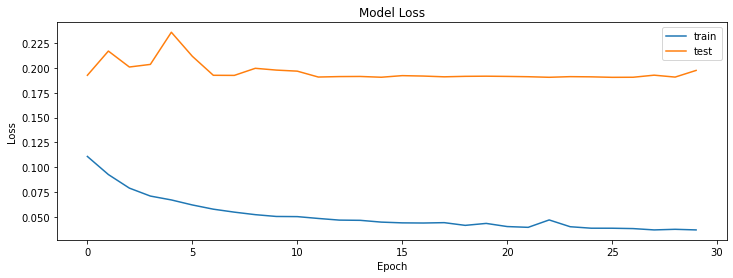

In [51]:
# history plot for accuracy
plt.figure(figsize=(12,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

## 7. Using the output prediction 

In [18]:
#https://stackoverflow.com/questions/55779286/valueerror-unknown-activation-function-my-custom-activation-function
best_model_1 = tf.keras.models.load_model('H:\Case Study\Self Driving Case Study\Checkpoints\envidea\envidea-weights.15-0.19.hdf5', 
                                          custom_objects={'custom_activation':custom_activation})
all_pred = []

for i in X_val[1000:2000]:
    i = cv2.resize(i, (200,66))
    i = i/255.0
    i = np.expand_dims(i, axis=0)
    prediction = best_model_1.predict(i)
    all_pred.extend(prediction[0])

In [19]:
(set(all_pred))

{-0.08536789}

### 7.1 Making the video using the images we have so that we can rotate the steering using the video

In [1]:
#https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/

#we have X which is a list contains the path of each image
image_array = []
for i in X:
    img = cv2.imread(i)
    image_array.append(img)

out = cv2.VideoWriter('H:\Case Study\Self Driving Case Study\envidiamlp\Self_Driving_Car.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, (img.shape[1], img.shape[0]))
for j in range(len(image_array)):
    out.write(image_array[j])
out.release()

NameError: name 'X' is not defined

### 7.2 Rotate the steering as per the prediction

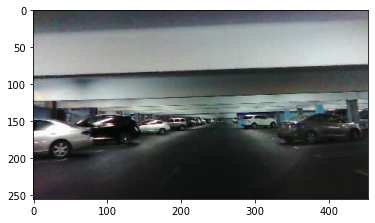

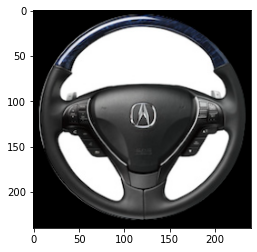

error: OpenCV(3.4.8) C:\projects\opencv-python\opencv\modules\highgui\src\window.cpp:724: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


In [26]:
#to rotate the steering image refer https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
#steering_image
model_1 = tf.keras.models.load_model('H:\Case Study\Self Driving Case Study\Checkpoints\envidea\envidea-weights.15-0.19.hdf5', 
                                          custom_objects={'custom_activation':custom_activation})
steering_img = cv2.imread('H:\Case Study\Self Driving Case Study\Autopilot-TensorFlow-master\Autopilot-TensorFlow-master\steering_wheel_image.jpg')
rows, cols = steering_img.shape[0], steering_img.shape[1]

cap = cv2.VideoCapture('H:\Case Study\Self Driving Case Study\envidiamlp\Self_Driving_Car.avi')

smoothed_angle = 0
while True:
    ret, frame = cap.read()
    resized_frame = cv2.resize(frame, (200,66))
    resized_frame = resized_frame/255.0
    resized_frame = np.expand_dims(resized_frame,axis=0)
    degrees = (model_1.predict(resized_frame) * 180)/scipy.pi  #to convert the radians to degrees
    
    plt.imshow(frame)
    plt.show()
#     cv2.imshow('frame', frame)
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0/2 * pow(abs(degrees - smoothed_angle), 2.0/3.0) * (degrees-smoothed_angle) / abs(degrees-smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), -degrees, 1)
    dst = cv2.warpAffine(steering_img, M, (cols,rows))
    plt.imshow(dst)
    plt.show()
#     cv2.imshow('steering_wheel', dst)
    
    if cv2.waitKey(1)==27:
        break
        
cv2.destroyAllWindows()
cap.release()